# Imports

In [1]:
# Starts the autoreload extension, which allows editing the .py files with the notebook running and automatically imports the latest changes

%load_ext autoreload
%autoreload 2

# Imports all the libraries used

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import accuracy_score, confusion_matrix
from umap import UMAP
from tqdm import tqdm
import cv2 as cv

from functools import partial

import jax
from jax import numpy as jnp
import haiku as hk
import optax

import resnet
import data
import model, network
import pickle

In [2]:
assert jax.local_device_count() >= 8, "TPUs not detected"

In [3]:
NUM_CLASSES = 4
SEED = 12
BATCH_SIZE = 128

jax.config.update("jax_debug_nans", False)
classes = ['Normal', 'Pneumonia-Bacterial', 'COVID-19', 'Pneumonia-Viral']

rng = jax.random.PRNGKey(SEED)

# Load data

In [4]:
(x_train, y_train), (x_test, y_test) = data.load_data('.', rng, test_size = 0.1)

x_all = np.concatenate([x_test, x_train])
y_all = np.concatenate([y_test, y_train])

tcmalloc: large alloc 7241465856 bytes == 0x8abcc000 @  0x7f0f90336680 0x7f0f90357824 0x7f0f858c84ce 0x7f0f8591e00e 0x7f0f8591ec4f 0x7f0f859c0924 0x5f2cc9 0x5f30ff 0x5705f6 0x568d9a 0x5f5b33 0x56bc9b 0x568d9a 0x5f5b33 0x56fb87 0x568d9a 0x5f5b33 0x56bc9b 0x568d9a 0x68cdc7 0x5ff5d4 0x5c3cb0 0x56aadf 0x501148 0x56c422 0x501148 0x56c422 0x501148 0x504d56 0x56acb6 0x5f5956
tcmalloc: large alloc 7241465856 bytes == 0x244514000 @  0x7f0f90336680 0x7f0f90357824 0x7f0f90357b8a 0x7f0c724f1c37 0x7f0c724a45eb 0x7f0c724b57a6 0x7f0c724b66dd 0x7f0c6e31fb09 0x7f0c6e3231a0 0x7f0c721d1302 0x7f0c6f8cc220 0x7f0c6f8cc910 0x7f0c6f8a7e95 0x7f0c6f8ae686 0x7f0c6f8b0434 0x7f0c6d4b03bf 0x7f0c6d2299a8 0x7f0c6d219540 0x5f2cc9 0x5f3010 0x50bf55 0x56fb87 0x568d9a 0x5f5b33 0x5f5308 0x6655bd 0x5f28fe 0x56c332 0x568d9a 0x5f5b33 0x5f5369
tcmalloc: large alloc 7241465856 bytes == 0x3f65fe000 @  0x7f0f90336680 0x7f0f90357824 0x7f0f90357b8a 0x7f0c724f1c37 0x7f0c724a45eb 0x7f0c724b57a6 0x7f0c724b66dd 0x7f0c6e31fb09 0x7f0c6e

In [5]:
# Defines network
def forward(batch, is_training, return_representation = False, return_gradcam = False, gradcam_counterfactual = False):
    net = resnet.ResNet18(num_classes = NUM_CLASSES, resnet_v2 = True)
    if return_representation:
        return net.embedding(batch, is_training, embedding_depth=0)
    elif return_gradcam:
        return net.gradcam(batch, is_training, gradcam_depth=0, counterfactual=gradcam_counterfactual)
    else:
        return net(batch, is_training)

net = hk.transform_with_state(forward)
schedule = optax.cosine_decay_schedule(1e-1, 30 * (len(x_train) // BATCH_SIZE))
optim = optax.adamw(schedule, weight_decay = 1e-3)

In [6]:
def basemodel_process(x): return np.array(x)

# Gets functions for the model
net_container = network.create(net, optim, BATCH_SIZE, shape = (10, 256, 256, 3))
basemodel = model.train_model("basemodel", net_container, basemodel_process, x_train, y_train, x_test, y_test)

tcmalloc: large alloc 6517948416 bytes == 0x5fcbfe000 @  0x7f0f90336680 0x7f0f90357824 0x7f0f858c84ce 0x7f0f85919c70 0x7f0f85919dd7 0x7f0f8591a029 0x7f0f8591cf4d 0x7f0f8591d289 0x7f0f859bec71 0x5f2cc9 0x5f3010 0x5700f3 0x5f5956 0x56aadf 0x568d9a 0x5f5b33 0x56fb87 0x568d9a 0x68cdc7 0x5ff5d4 0x5c3cb0 0x56aadf 0x501148 0x56c422 0x501148 0x56c422 0x501148 0x504d56 0x56acb6 0x5f5956 0x56aadf


Model loaded from models/basemodel.pickle


# Grad-CAM for the original model

100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.86it/s]
115it [00:10, 11.44it/s]


Perc correct 0.6604


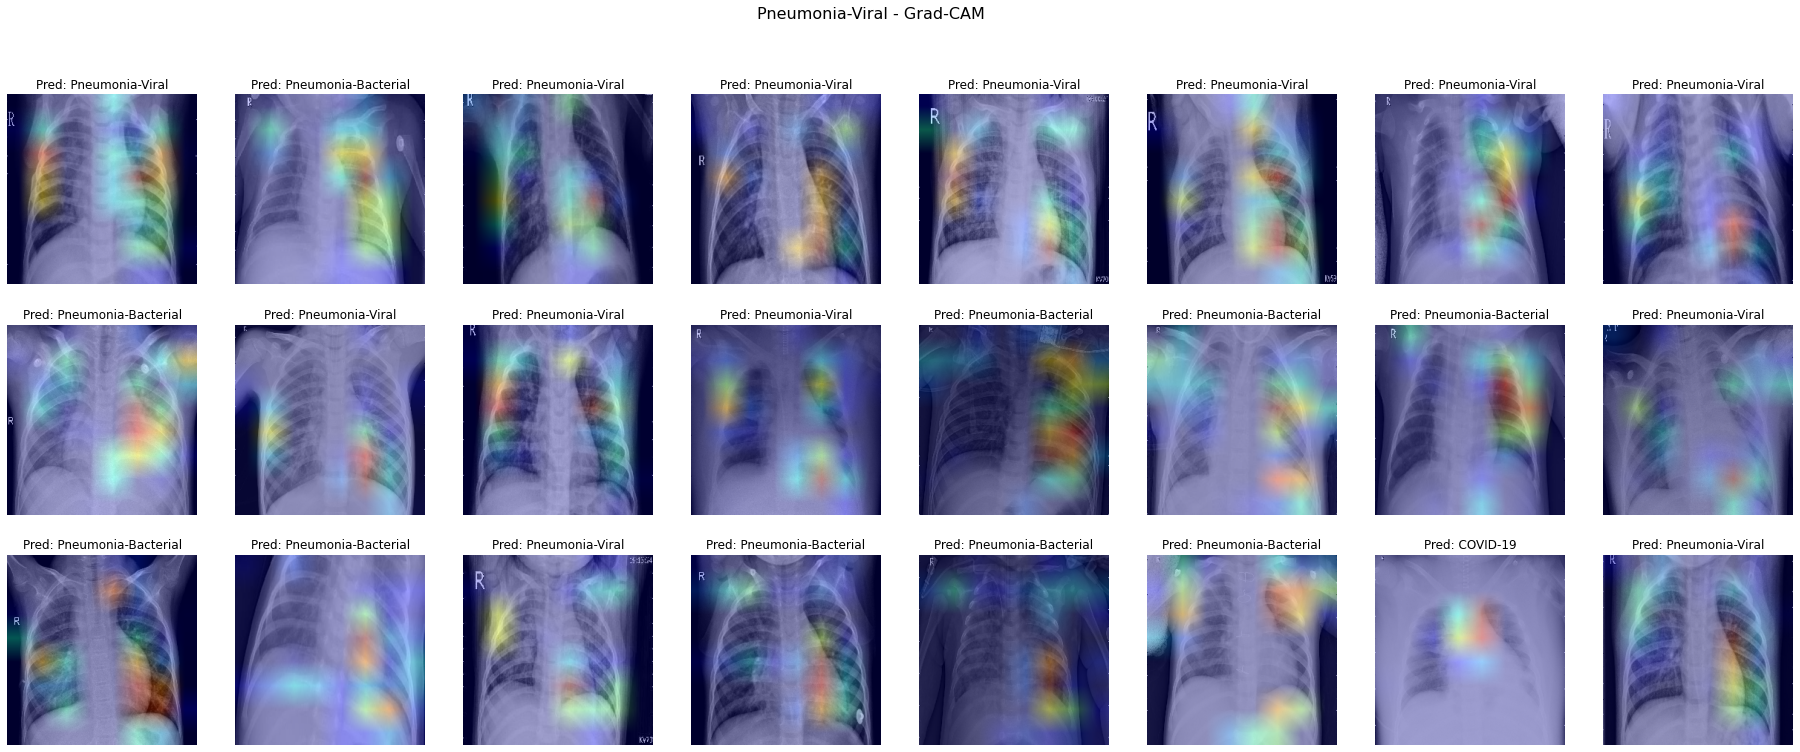

In [14]:
import utils
import gradcam

# First, we generate the Grad-CAM and the predictions
basemodel_y_pred = net_container.predict(basemodel.params, basemodel.state, x_test, False, return_gradcam=False, training=True, verbose=True)
basemodel_cams = gradcam.generate_from_data(x_test, y_test, net, basemodel.params, basemodel.state)

In [ ]:
# Then, we plot the results with matplotlib
gradcam.plot_gradcams_from_class(utils.CLASS_NORMAL, basemodel.x_test_proc, basemodel.y_test, basemodel_y_pred, basemodel_cams)

Perc correct 0.8370


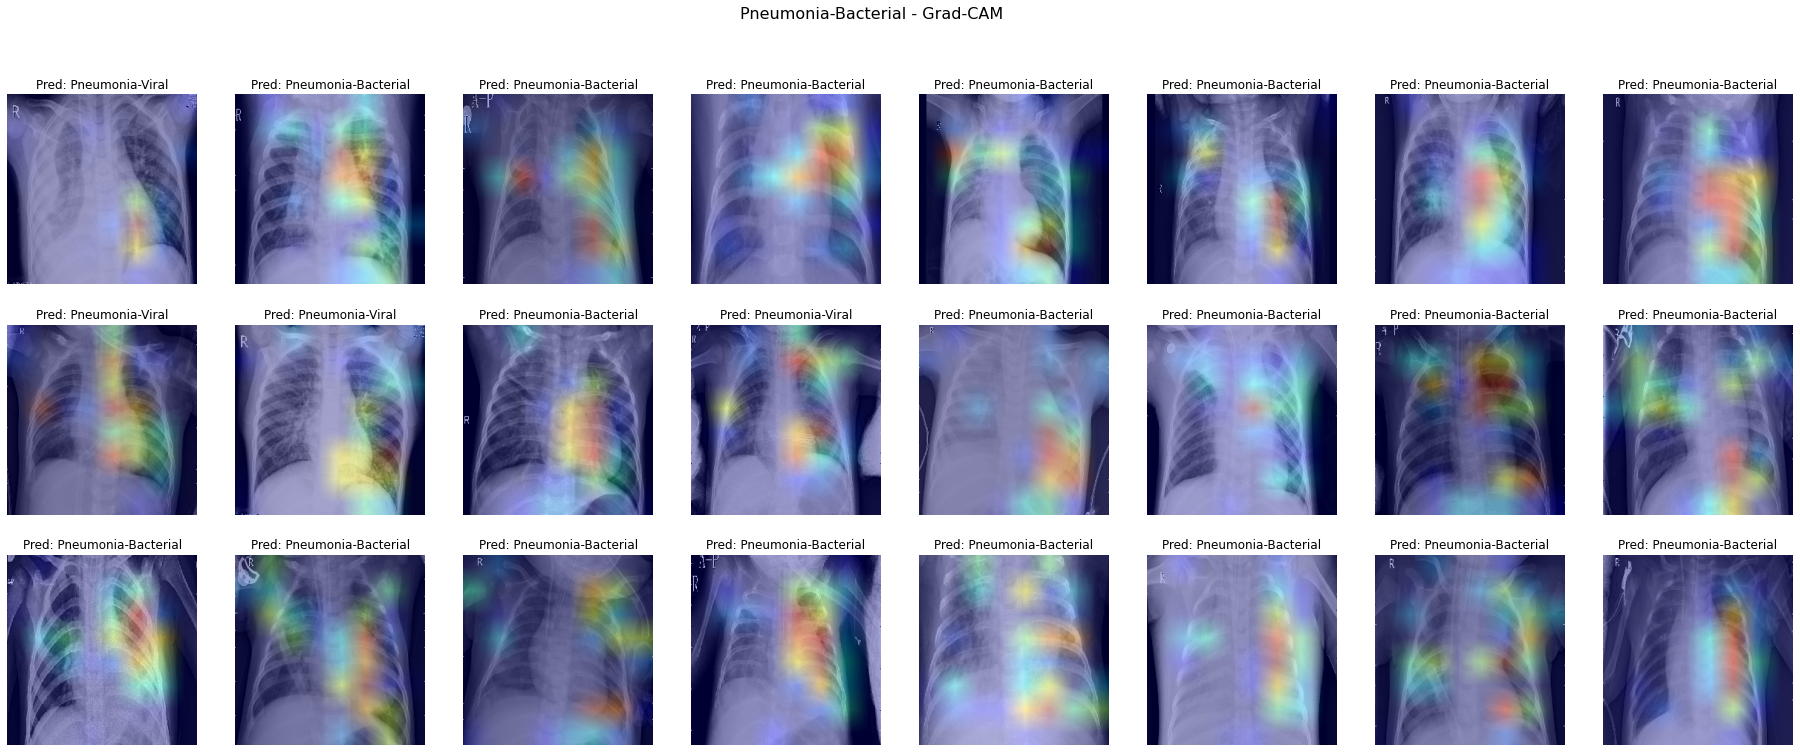

In [17]:
# Then, we plot the results with matplotlib
gradcam.plot_gradcams_from_class(utils.CLASS_BACT, basemodel.x_test_proc, basemodel.y_test, basemodel_y_pred, basemodel_cams)

Perc correct 0.6604


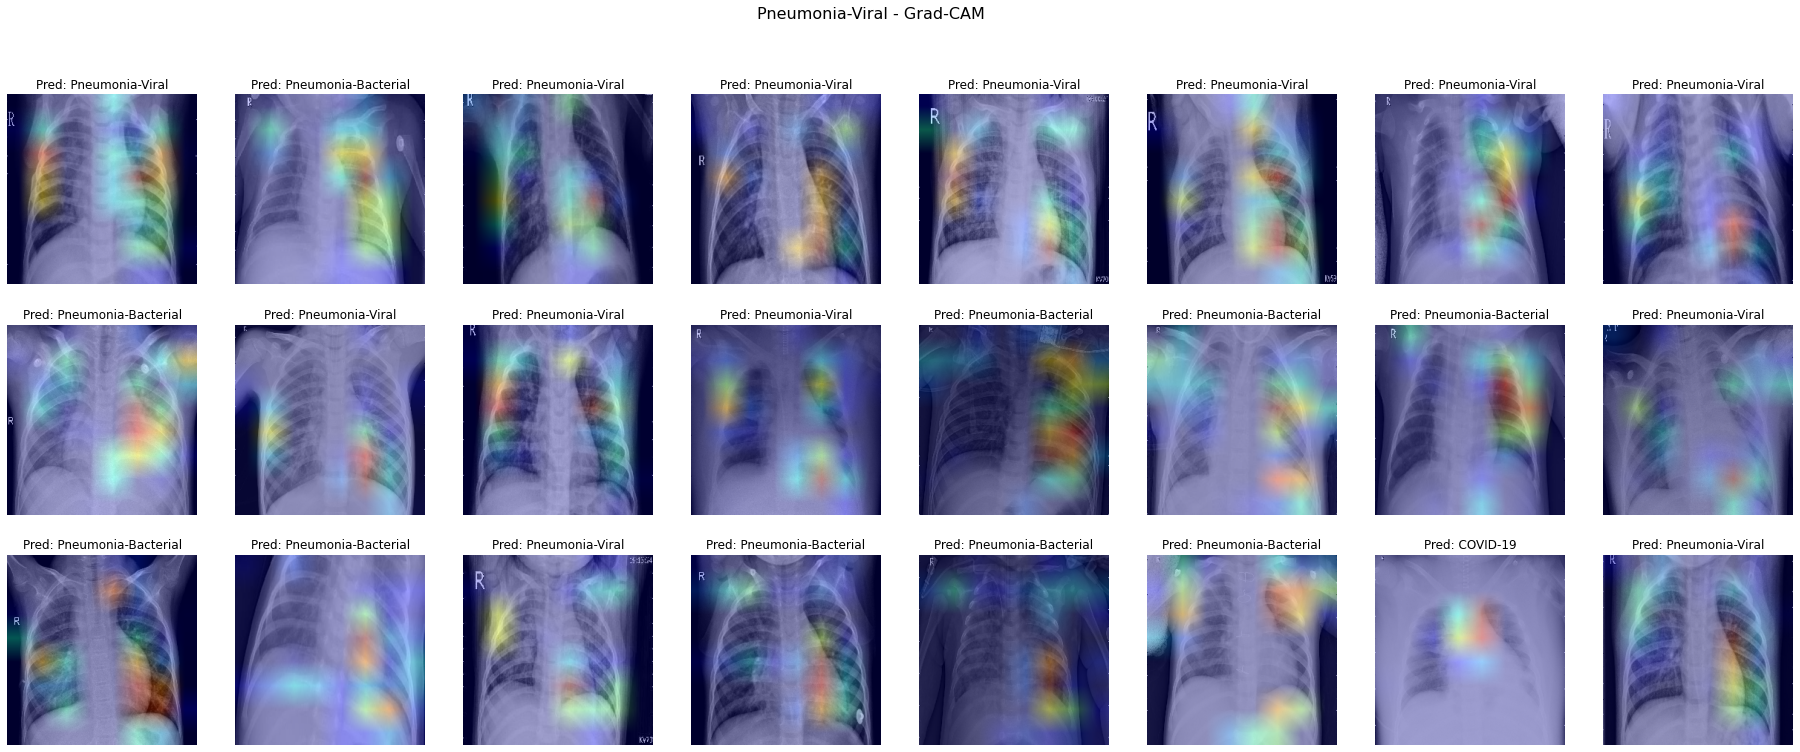

In [22]:
# Then, we plot the results with matplotlib
gradcam.plot_gradcams_from_class(utils.CLASS_VIRAL, basemodel.x_test_proc, basemodel.y_test, basemodel_y_pred, basemodel_cams)

Perc correct 0.9530


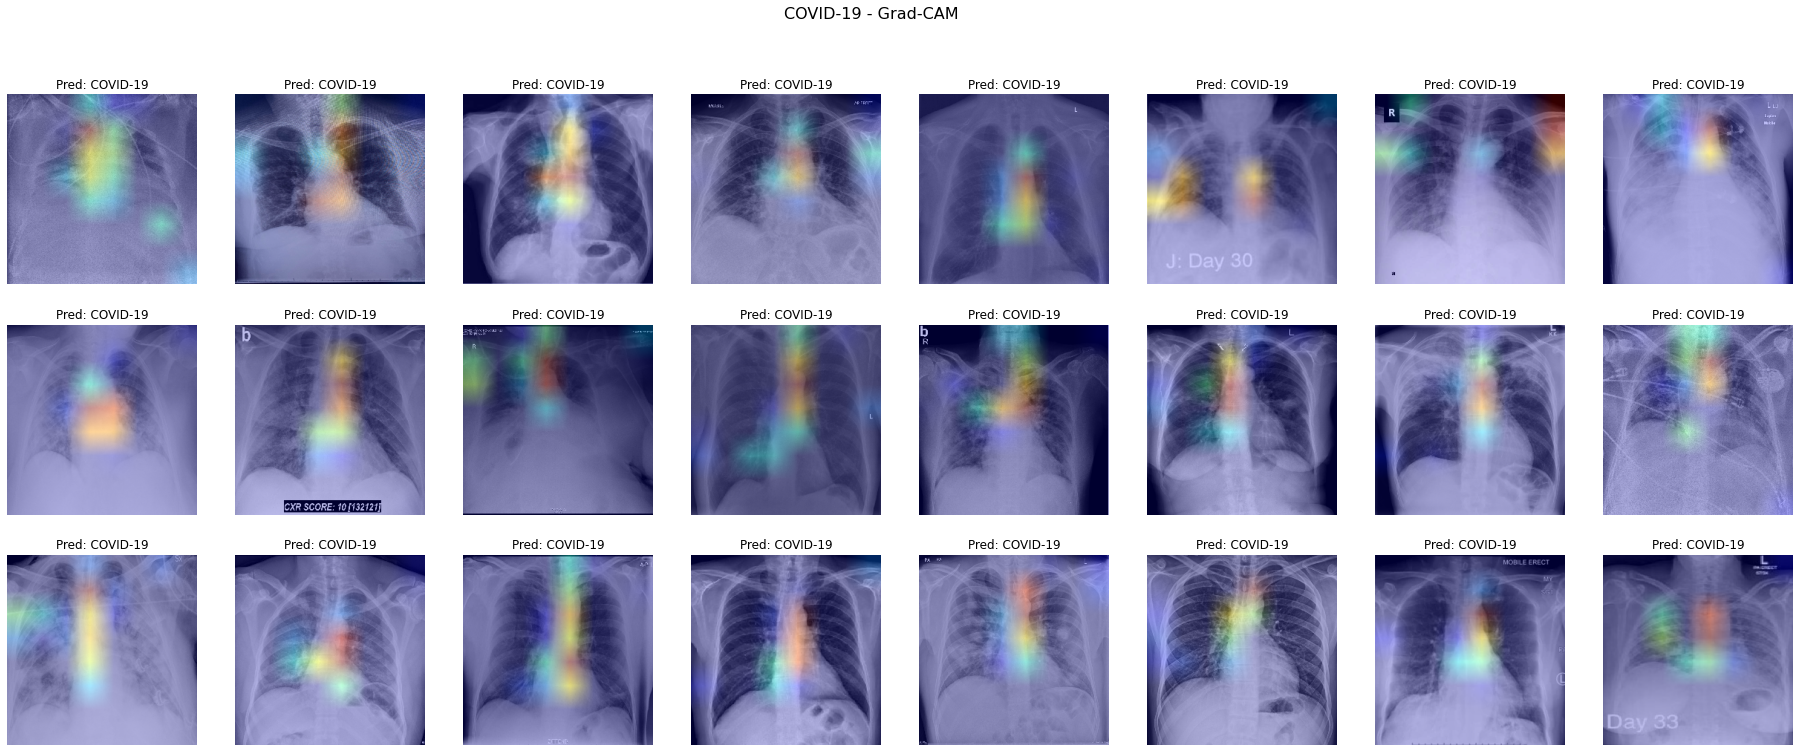

In [21]:
# Then, we plot the results with matplotlib
gradcam.plot_gradcams_from_class(utils.CLASS_COVID, basemodel.x_test_proc, basemodel.y_test, basemodel_y_pred, basemodel_cams)

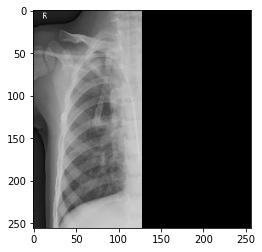

In [8]:
import cv2 as cv

img = np.array(x_train[0,:,:,:])
img = (img*255).astype(np.uint8)

#img[0:img.shape[0]//5,] = 0
img[:,img.shape[0]//2:img.shape[0],] = 0
plt.imshow(img)

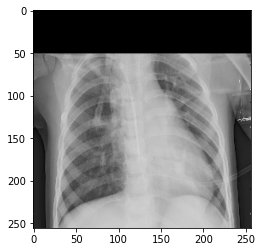

In [18]:
import cv2 as cv

img = np.array(x_train[0,:,:,:])
img = (img*255).astype(np.uint8)

img[0:img.shape[0]//5,] = 0
#img[:,img.shape[0]//2:img.shape[0],] = 0
plt.imshow(img)

# Without right lung

In [9]:
def halfmodel_fn(dataset):
    dataset = np.array(dataset)
    dataset[:,:,dataset.shape[1]//2:dataset.shape[1],] = 0
    return jnp.array(dataset)

def topmodel_fn(dataset):
    dataset = np.array(dataset)
    dataset[:,0:int(dataset.shape[1]*0.1),] = 0
    return jnp.array(dataset)

halfmodel = model.train_model("halfmodel", net_container, halfmodel_fn, x_train, y_train, x_test, y_test)
topmodel = model.train_model("topmodel", net_container, topmodel_fn, x_train, y_train, x_test, y_test)

tcmalloc: large alloc 6517948416 bytes == 0x8abcc000 @  0x7f0f90336680 0x7f0f90357824 0x7f0f858c84ce 0x7f0f85919c70 0x7f0f85919dd7 0x7f0f8591a029 0x7f0f8591cf4d 0x7f0f8591d289 0x7f0f859bec71 0x5f2cc9 0x5f3010 0x5700f3 0x5f5956 0x56aadf 0x568d9a 0x5f5b33 0x56fb87 0x568d9a 0x68cdc7 0x5ff5d4 0x5c3cb0 0x56aadf 0x501148 0x56c422 0x501148 0x56c422 0x501148 0x504d56 0x56acb6 0x5f5956 0x56aadf
tcmalloc: large alloc 6517948416 bytes == 0x906bfe000 @  0x7f0f90336680 0x7f0f90357824 0x7f0c96ff8c47 0x7f0c96fe2286 0x7f0c96fdf4a9 0x7f0c9617c6ff 0x7f0c9ac05175 0x7f0c9ac009a7 0x7f0c9abfb0a5 0x7f0c961788c2 0x7f0c96170395 0x7f0c71fb30d9 0x7f0c6f8a6966 0x7f0c724e1de1 0x7f0c724df823 0x7f0c724ccaa5 0x7f0f90103609 0x7f0f9023f293
100%|█████████████████████████████████| 64/64 [00:07<00:00,  8.84it/s, loss=0.10, acc=0.97, val_loss=0.47, val_acc=0.85]


Model saved to models/halfmodel.pickle


tcmalloc: large alloc 6517948416 bytes == 0x906bfe000 @  0x7f0f90336680 0x7f0f90357824 0x7f0f858c84ce 0x7f0f85919c70 0x7f0f85919dd7 0x7f0f8591a029 0x7f0f8591cf4d 0x7f0f8591d289 0x7f0f859bec71 0x5f2cc9 0x5f3010 0x5700f3 0x5f5956 0x56aadf 0x568d9a 0x5f5b33 0x56fb87 0x568d9a 0x68cdc7 0x5ff5d4 0x5c3cb0 0x56aadf 0x501148 0x56c422 0x501148 0x56c422 0x501148 0x504d56 0x56acb6 0x5f5956 0x56aadf
tcmalloc: large alloc 6517948416 bytes == 0x8abcc000 @  0x7f0f90336680 0x7f0f90357824 0x7f0c96ff8c47 0x7f0c96fe2286 0x7f0c96fdf4a9 0x7f0c9617c6ff 0x7f0c9ac05175 0x7f0c9ac009a7 0x7f0c9abfb0a5 0x7f0c961788c2 0x7f0c96170395 0x7f0c71fb30d9 0x7f0c6f8a6966 0x7f0c724e1de1 0x7f0c724df823 0x7f0c724ccaa5 0x7f0f90103609 0x7f0f9023f293


Model loaded from models/topmodel.pickle


100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.50it/s]


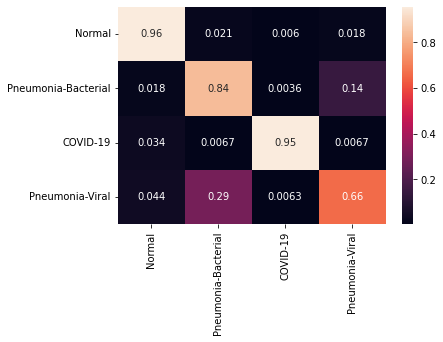

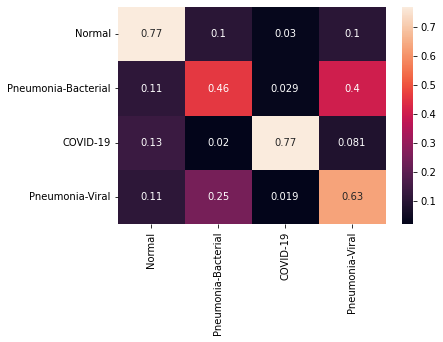

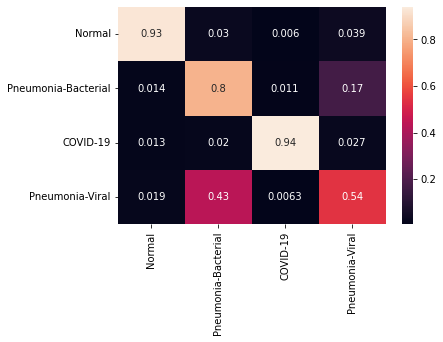

In [10]:
halfmodel_y_pred = net_container.predict(halfmodel.params, halfmodel.state, x_test, False, return_gradcam=False, training=True, verbose=True)
topmodel_y_pred = net_container.predict(topmodel.params, topmodel.state, x_test, False, return_gradcam=False, training=True, verbose=True)

model.plot_confusion_matrix(basemodel, basemodel_y_pred)
model.plot_confusion_matrix(halfmodel, halfmodel_y_pred)
model.plot_confusion_matrix(topmodel, topmodel_y_pred)

115it [00:01, 71.60it/s]


Perc correct 0.4565


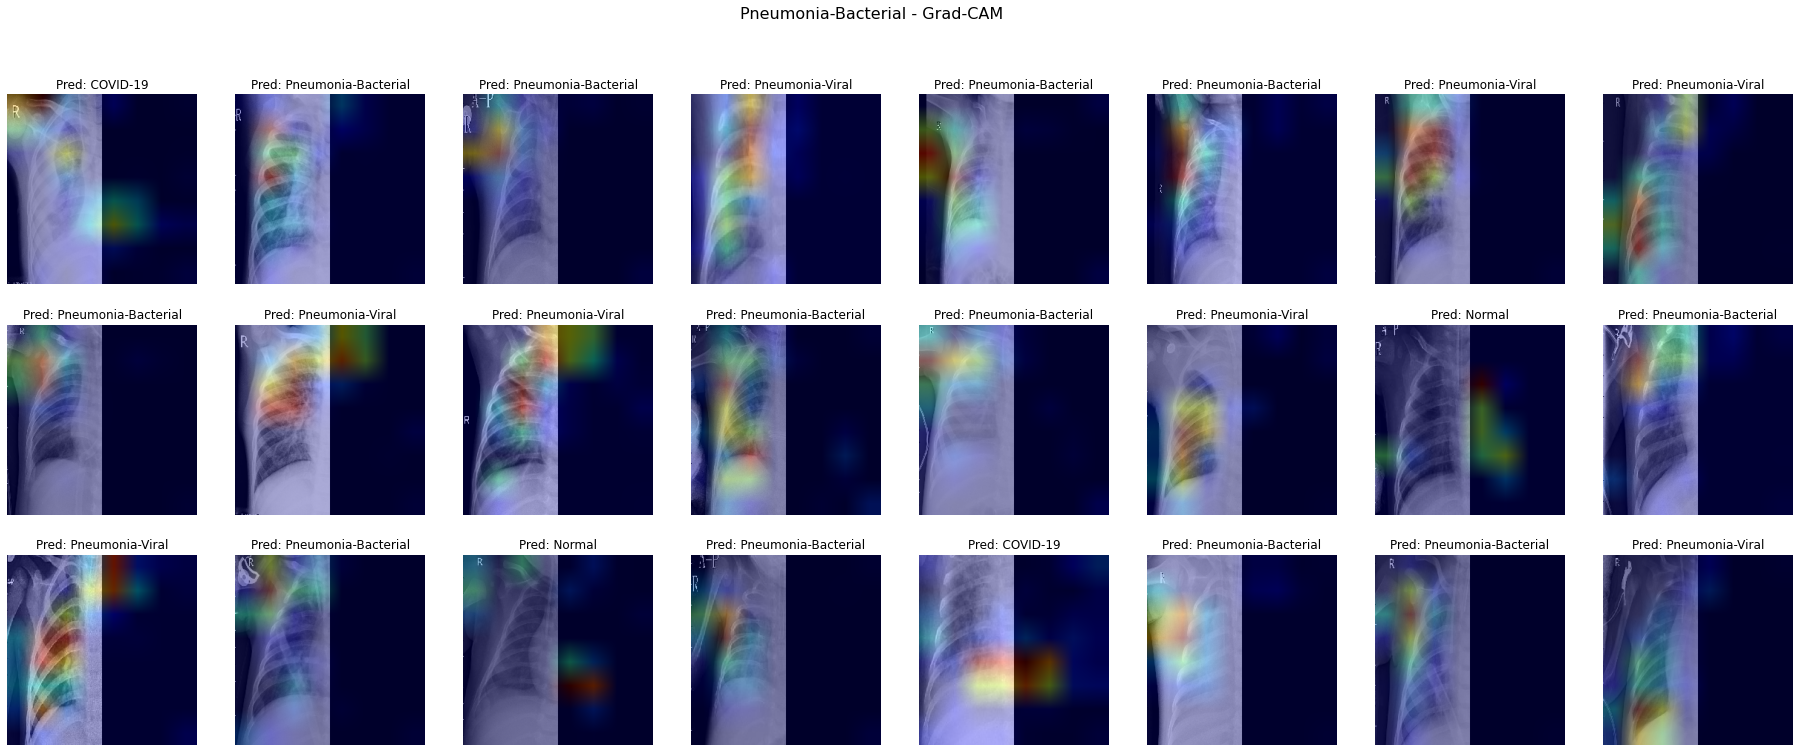

In [19]:
gradcam.plot_gradcams_from_class(utils.CLASS_BACT, halfmodel.x_test_proc, halfmodel.y_test, halfmodel_y_pred, halfmodel_cams)

In [ ]:
halfmodel_cams = gradcam.generate_from_data(x_test, y_test, net, halfmodel.params, halfmodel.state)
topmodel_cams = gradcam.generate_from_data(x_test, y_test, net, topmodel.params, topmodel.state)

115it [00:10, 10.91it/s]


Perc correct 0.9396


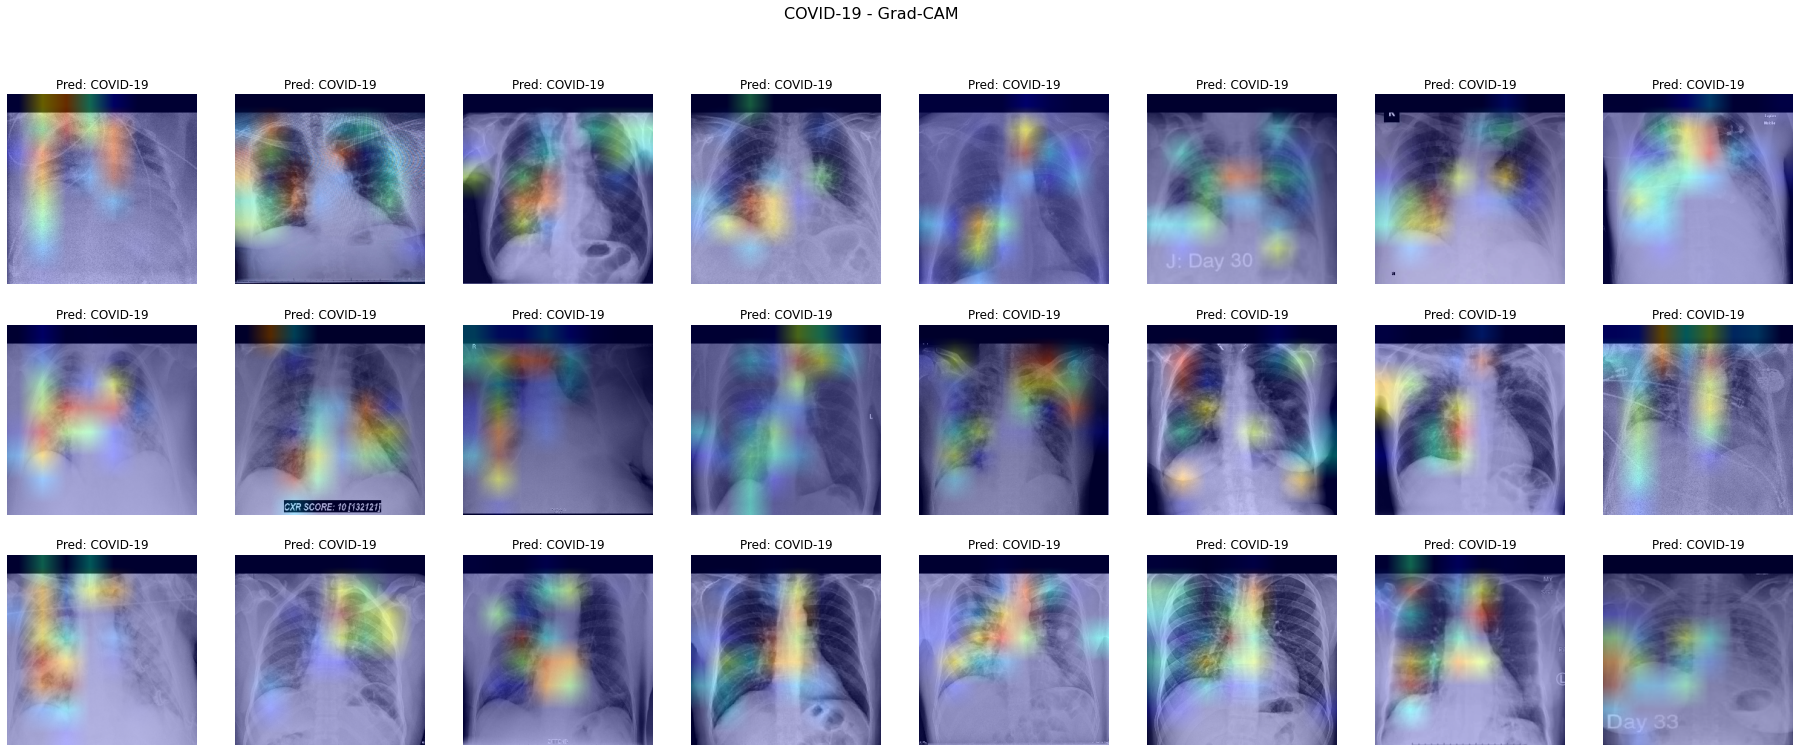

In [20]:
gradcam.plot_gradcams_from_class(utils.CLASS_COVID, topmodel.x_test_proc, topmodel.y_test, topmodel_y_pred, topmodel_cams)